In [514]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIR import *
import scipy as sp
import pickle

In [ ]:
## Default procedure

# Fit rT,rA for CH4/N2O to monte carlo Prather for uncertainty
# Fit r0, PIconc to present day conc and departure from concs line. Or inverse to pd emissions and pd cumulative emissions
# Fit r0,rT,rC using fixed rT/rC ratio for CO2

In [504]:
## Function that creates an empty emission dataframe

def empty_emissions(start_year,end_year):
    
    return pd.DataFrame(index = np.arange(start_year,end_year+1),columns=['CO2','N2O','CH4']).fillna(0.0)

## Data Acquisition

In [2]:
## Get Law Dome

Law_Dome = pd.read_csv('./Conc_fit_data/law2006.txt',index_col=0,skiprows=183,nrows=2188-184,delim_whitespace=True,usecols=[0,3,5,8],names=['Year','CH4','CO2','N2O'])

# Get NOAA atmospheric observations

obsv_concs = pd.read_csv('./Conc_fit_data/NOAA_Conc_data.csv',skiprows=4,header=None,index_col=0).dropna().iloc[:,:3].values
obsv_concs = pd.DataFrame(data=obsv_concs,index = np.arange(1979,2018),columns=['CO2','CH4','N2O'])

# Get CMIP6 concs (some harmonization of Law Dome and atmospheric observations:

CMIP6_concs = pd.read_csv('./CMIP_input_ems/Supplementary_Table_UoM_GHGConcentrations-1-1-0_annualmeans_v23March2017.csv',skiprows=21,index_col=0)

In [255]:
## Get my best estimate emission series generated by the emission script.

emissions = pd.read_csv('./Best_estimate_emissions_for_UnFaIR.csv',index_col=0)

In [224]:
## Get some RCP emisisons / concentrations / forcings

RCP = '85'
RCP_E = pd.read_csv('./RCP_data/RCP'+RCP+'_EMISSIONS.csv',skiprows=36,index_col=0)
RCP_C = pd.read_csv('./RCP_data/RCP'+RCP+'_MIDYEAR_CONCENTRATIONS.csv',skiprows=37,index_col=0)
RCP_forc = pd.read_csv('./Conc_fit_data/RCP'+RCP+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)
otherforc = RCP_forc.TOTAL_INCLVOLCANIC_RF.loc[:2012].values - RCP_forc.CO2CH4N2O_RF.loc[:2012].values

## Fitting Procedure description

- Compare our gas cycles with either observations OR (Methane / N2O) Prather's parametric model (vapour, temperature, burden sensitivities only).

- Fit our sensitivity parameters (rT / rA) to Holmes (CH4/N2O)

- Fit all the parameters (CO2) or r0 (CH4/N2O) to observed concentrations with a specified temperature response

- Booya

In [208]:
# Fitting to Holmes (2012)

# Define the water vapour equation

def Jacobson05(T):
    return 6.112 * np.exp( 6816 * ( 1 / 273.15 - 1 / T ) + 5.1309 * np.log( 273.15 / T ) )

# Get the temperature response used in Holmes (CMIP5 model mean)

CMIP5_RCP85_tas = pd.read_csv('/home/nleach/Documents/UnFaIR/5eqSCM/CMIP5_Prather_data/CMIP5_RCP85_tas_data.txt',skiprows=31,delim_whitespace=True,header=None,index_col=0,names=['Year','anom'])

# Convert to atmospheric temperature -> saturation pressure -> vapour content as in Holmes

T_atmos = 251.9 + 0.94 * ( CMIP5_RCP85_tas - CMIP5_RCP85_tas.loc[2010] )
sat_p_atmos = Jacobson05(T_atmos)
q_atmos = 2.45 * ( 1 + 1.5 * (sat_p_atmos - sat_p_atmos.loc[2010]) / sat_p_atmos.loc[2010] )

In [209]:
# FOR CH4:

# Provide parameters as given in Holmes

pd_ems = 352 # Tg/yr
pd_conc = 1800
tau_other = (1/200+1/120+1/150)**(-1) # All non-OH sinks encapsulated here

emis2conc = 28.97/(5.148*16)

# Sensitivities given in Prather:

alph_T = -3. 
alph_q = -0.32 
alph_CH4 = 0.31

ems = RCP_E.CH4.loc[2010:2100] * pd_ems / RCP_E.CH4.loc[2010]

nat_ems = 202 # Natural emissions given in Prather

# Initialize the model

C = np.zeros(ems.size)
C[0] = pd_conc
tau_OH = np.zeros(ems.size)
tau_OH[0] = 11.2
tau = np.zeros(ems.size)
tau[0] = (1/tau_OH[0] + 1/tau_other)**(-1)

for i,t in enumerate(ems.loc[2010:2100].index.values[:-1]):
    
    C[i+1] = emis2conc * (ems.loc[t]+nat_ems) * tau[i] * (1 - np.exp(-1/tau[i])) + C[i] * np.exp(-1/tau[i])
    
    tau_OH[i+1] = tau_OH[i] * (T_atmos.loc[t+1]/T_atmos.loc[t])**(alph_T) * (q_atmos.loc[t+1]/q_atmos.loc[t])**(alph_q) * (C[i+1]/C[i])**(alph_CH4)# * (NOx_ems[t+1]/NOx_ems[t])**(alph_NOx)
    
    tau[i+1] = (1/tau_OH[i+1] + 1/tau_other)**(-1)

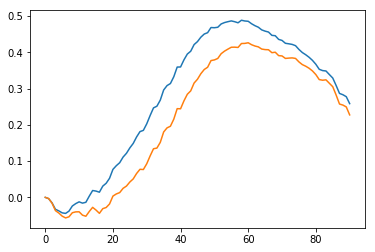

In [210]:
## So we have a defined concentration & temperature pathway, so all we need is to calculate alpha over these

def moving_average(a, n=4) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# AND MINIMIZE:

# Baseline the temp response to our best T_response baseline value

CMIP5_T_response = CMIP5_RCP85_tas - CMIP5_RCP85_tas.loc[1861:1880].mean() + -0.016286

gas_params = default_gas_params()

tau_UF = gas_params.loc['tau1':'tau4','CH4']

g1 = tau_UF[0] * (1- (1+100/tau_UF[0])*np.exp(-100/tau_UF[0]))
g0 = (np.sinh(tau_UF[0]*(1-np.exp(-100/tau_UF[0]))/g1))**(-1)

r0 = 9.36

# r0 is set to the optimal value without sensitivities (ie. the following procedure with others set to 0)

def fit_CH4_tau(x):
    
    alpha = g0 * np.sinh( ( r0 + x[1] * CMIP5_T_response.loc[2010:2100].values.flatten() + x[2] * (C - gas_params.loc['PI_conc','CH4'])/emis2conc ) / g1 )
    
    return np.sum((np.diff(tau_UF.loc['tau1'] * alpha) - np.diff(tau))**2)

resultminimize = sp.optimize.minimize(fit_CH4_tau,[9,-0.36,0.0003],method='TNC')
x = resultminimize['x']

## Plot the result:

alpha = g0 * np.sinh( ( r0 + x[1] * CMIP5_T_response.loc[2010:2100].values.flatten() + x[2] * (C - gas_params.loc['PI_conc','CH4'])/emis2conc ) / g1 )
our_fit = tau_UF.loc['tau1'] * alpha

plt.plot(tau - tau[0])
plt.plot(our_fit - our_fit[0])

In [211]:
## SO our rT / rA for CH4 are:

gas_params.loc[['rT','rA'],'CH4'] = x[1:]

In [212]:
## FOR N2O:

alph_N2O = -0.065
emis2conc = 28.97/(5.148*28)

ems_N2O = RCP_E.N2O.loc[range(2010,2101)] * 6.6 / RCP_E.N2O.loc[2010] # RCP scaled to Prather

nat_ems = 10.5

C = np.zeros(ems_N2O.size)
tau = np.zeros(ems_N2O.size)
C[0] = 321
tau[0] = 116

for i,t in enumerate(ems_N2O.index.values[:-1]):
    
    C[i+1] = emis2conc * (ems_N2O.loc[t]+nat_ems) * tau[i] * (1 - np.exp(-1/tau[i])) + C[i] * np.exp(-1/tau[i])
    
    tau[i+1] = tau[i] * (C[i+1] / C[i])**(alph_N2O)

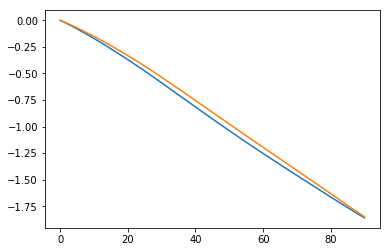

In [213]:
tau_UF = gas_params.loc['tau1':'tau4','N2O']

g1 = tau_UF[0] * (1- (1+100/tau_UF[0])*np.exp(-100/tau_UF[0]))
g0 = (np.sinh(tau_UF[0]*(1-np.exp(-100/tau_UF[0]))/g1))**(-1)

r0=66.8

# r0 is set to the optimal value without sensitivities (ie. the following procedure with othe r set to 0)

def fit_N2O_tau(x):
    
    alpha = g0 * np.sinh( ( r0 + x[1] * (C - gas_params.loc['PI_conc','N2O'])/emis2conc ) / g1 )
    
    return np.sum((np.diff(tau_UF.loc['tau1'] * alpha) - np.diff(tau))**2)

resultminimize = sp.optimize.minimize(fit_N2O_tau,[50,0.0003],method='Nelder-Mead')
x = resultminimize['x']

alpha = g0 * np.sinh( ( r0 + x[1] * (C - gas_params.loc['PI_conc','N2O'])/emis2conc ) / g1 )
our_fit = tau_UF.loc['tau1'] * alpha

plt.plot(tau - tau[0])
plt.plot(our_fit - our_fit[0])

In [214]:
gas_params.loc['rA','N2O'] = x[1]

In [215]:
## Now we need a reasonable temperature response to fit to:

## Get a temp response
forcings = pd.read_csv('./Conc_fit_data/Annualforcings_Mar2014_GHGrevised.txt',skiprows=3,sep='\t',index_col=0)
empty_ems = pd.DataFrame(index=forcings.index,columns=['CO2','CH4','N2O']).fillna(0.)
T_ant = UnFaIR(emissions_in=empty_ems,F_ext=forcings.Anthrototal.values)['T']
T_nat = UnFaIR(emissions_in=empty_ems,F_ext=(forcings.Total.values - forcings.Anthrototal.values))['T']

T_response = (T_ant*0.912621338044 + T_nat*0.395722694204).loc[range(1765,2015)]
T_response -= T_response.loc[1765]

In [283]:
def fitting_remaining_params(x,s,observed_concs):
    
    fit_params = gas_params.copy()
    
    if s == 'CO2':
        fit_params.loc['r0':'rT'][s] = np.array([x[0],x[1],x[2]])
    if s == 'CH4':
        fit_params.loc['r0'][s] = x[0]
    if s == 'N2O':
        fit_params.loc['r0'][s] = x[0]
        
    result = fit_gas_cycles(emissions,T_response,fit_params)
    
    scaling = (observed_concs.index.values>0).astype(int) + 4 * (observed_concs.index.values>1980).astype(int)
    
    return np.sum(scaling*((result[s].loc[observed_concs.index] - observed_concs[s]).dropna().values)**2)# * (observed_concs.index.values-1850))

bnds = ((25,40),(0.0,0.04),(2,6))
CO2_grad_fit = sp.optimize.minimize(fitting_remaining_params,[32,0.02,4],args=('CO2',CMIP6_concs[['CO2','CH4','N2O']].loc[1850:2012]),method='TNC',bounds=bnds)
bnds = ((7,10))
CH4_grad_fit = sp.optimize.minimize(fitting_remaining_params,9,args=('CH4',CMIP6_concs[['CO2','CH4','N2O']].loc[1850:2012]),method='Powell')#,bounds=bnds)
bnds = ((40,80))
N2O_grad_fit = sp.optimize.minimize(fitting_remaining_params,65,args=('N2O',CMIP6_concs[['CO2','CH4','N2O']].loc[1850:2012]),method='Powell')#,bounds=bnds)

/home/nleach/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [284]:
## Now set these parameter values:

x = CO2_grad_fit['x']
gas_params.loc['r0':'rT','CO2'] = np.array([x[0],x[1],x[2]])
x = CH4_grad_fit['x']
gas_params.loc['r0','CH4'] = x
x = N2O_grad_fit['x']
gas_params.loc['r0','N2O'] = x

                      CO2         CH4         N2O
a1               0.217300    1.000000    1.000000
a2               0.224000    0.000000    0.000000
a3               0.282400    0.000000    0.000000
a4               0.276300    0.000000    0.000000
tau1       1000000.000000    9.150000  116.000000
tau2           394.400000    1.000000    1.000000
tau3            36.540000    1.000000    1.000000
tau4             4.304000    1.000000    1.000000
r0              31.089145    9.283318   68.882429
rC               0.012054    0.000000    0.000000
rT               3.932987   -0.294119    0.000000
rA               0.000000    0.000252   -0.000891
PI_conc        278.000000  700.000000  273.000000
emis2conc        0.468952    0.351714    0.200980


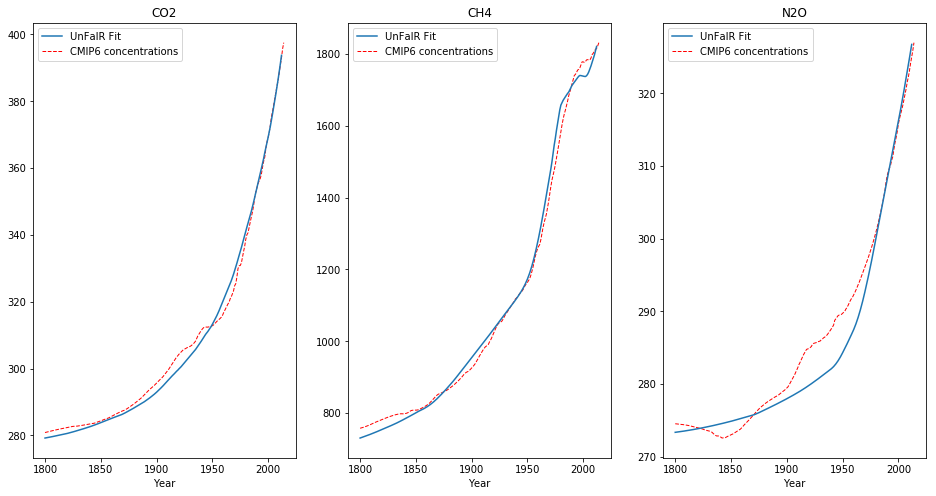

In [285]:
result = UnFaIR(emissions_in=emissions,F_ext=otherforc,gas_params=gas_params)

print(result['gas_params'])

fig,ax=plt.subplots(1,3,figsize=(16,8))
for i,s in enumerate(['CO2','CH4','N2O']):
    result['C'][s].loc[1800:].plot(ax=ax[i],label='UnFaIR Fit')
    #obsv_concs[s].plot(ax=ax[i],marker='x',linewidth=0,ms=2,color='r',label='NOAA observation (atmos)')
    #Law_Dome[s].loc[1800:].plot(ax=ax[i],marker='x',linewidth=0,ms=2,color='k', label='Law Dome measurement')
    CMIP6_concs[s].loc[1800:].plot(ax=ax[i],linestyle='--',linewidth=1,ms=2,color='r',label='CMIP6 concentrations',zorder=0)
    ax[i].set_title(s)
    ax[i].set_xlabel('Year')
    ax[i].legend()

## Fitting vs the RCPs

In [496]:
RCPs = ['3PD','45','6','85']
RCP_ems = {}
RCP_C = {}
otherforc = {}
total_forc = {}

# We should really fit the thermal response first (using total forcing), then the gas cycles

for s in RCPs:
    RCP_E = pd.read_csv('./RCP_data/RCP'+s+'_EMISSIONS.csv',skiprows=36,index_col=0)
    RCP_ems[s] = pd.DataFrame(data = np.array([RCP_E[['OtherCO2','FossilCO2']].sum(axis=1).values,RCP_E['CH4'].values,RCP_E['N2O'].values]).T,columns=['CO2','CH4','N2O'],index = RCP_E.index)
    RCP_C[s] = pd.read_csv('./RCP_data/RCP'+s+'_MIDYEAR_CONCENTRATIONS.csv',skiprows=37,index_col=0)
    RCP_forc = pd.read_csv('./Conc_fit_data/RCP'+s+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)
    otherforc[s] = RCP_forc.TOTAL_INCLVOLCANIC_RF.values - RCP_forc.CO2CH4N2O_RF.values
    total_forc[s] = RCP_forc.TOTAL_INCLVOLCANIC_RF.loc[:2101].values

## import CMIP5 model mean temp response:

CMIP5_temps = {}

CMIP5_temps['3PD'] = pd.read_csv('./Conc_fit_data/CMIP5_model_mean_temp/icmip5_tas_Amon_modmean_rcp26_0-360E_-90-90N_n_000_mean1_anom_30.dat.txt',skiprows=29,delim_whitespace=True,names = ['Year','tas'], index_col=0)
CMIP5_temps['45'] = pd.read_csv('./Conc_fit_data/CMIP5_model_mean_temp/icmip5_tas_Amon_modmean_rcp45_0-360E_-90-90N_n_000_mean1_anom_30.dat.txt',skiprows=30,delim_whitespace=True,names = ['Year','tas'], index_col=0)
CMIP5_temps['6'] = pd.read_csv('./Conc_fit_data/CMIP5_model_mean_temp/icmip5_tas_Amon_modmean_rcp60_0-360E_-90-90N_n_000_mean1_anom_30.dat.txt',skiprows=29,delim_whitespace=True,names = ['Year','tas'], index_col=0)
CMIP5_temps['85'] = pd.read_csv('./Conc_fit_data/CMIP5_model_mean_temp/icmip5_tas_Amon_modmean_rcp85_0-360E_-90-90N_n_000_mean1_anom_30.dat.txt',skiprows=30,delim_whitespace=True,names = ['Year','tas'], index_col=0)

## Create an empty emissions set to match the forcing runs:

empty_emissions = pd.DataFrame(index = RCP_forc.loc[:2101].index, columns = ['CO2','CH4','N2O']).fillna(0.)

thermal_params = default_thermal_params()

def fit_thermal_params(x):
    
    fit_params = thermal_params.copy()
    fit_params.loc['d'] = [x[0],x[1]]
    fit_params.loc['q'] = np.array([x[2],x[3]])
    
    diff=0
    
    for s in RCPs:
                
        model_run = UnFaIR(empty_emissions,total_forc[s],thermal_params = fit_params)
        
        model_T_baselined = model_run['T']['Total'].loc[CMIP5_temps[s].index] - model_run['T']['Total'].loc[1861:1880].mean()
        
        CMIP5_T_baselined = CMIP5_temps[s] - CMIP5_temps[s].loc[1861:1880].mean()
        
        diff += np.sum((model_T_baselined.values.flatten() - CMIP5_T_baselined.values.flatten())**2)/np.sum(CMIP5_T_baselined.values.flatten()**2)
        
    return diff

thermal_params_fit = sp.optimize.minimize(fit_thermal_params,np.array([240,4,1.5,3]),method='Nelder-Mead')

           1         2
d  71.507508  3.284680
q   0.312707  0.425155


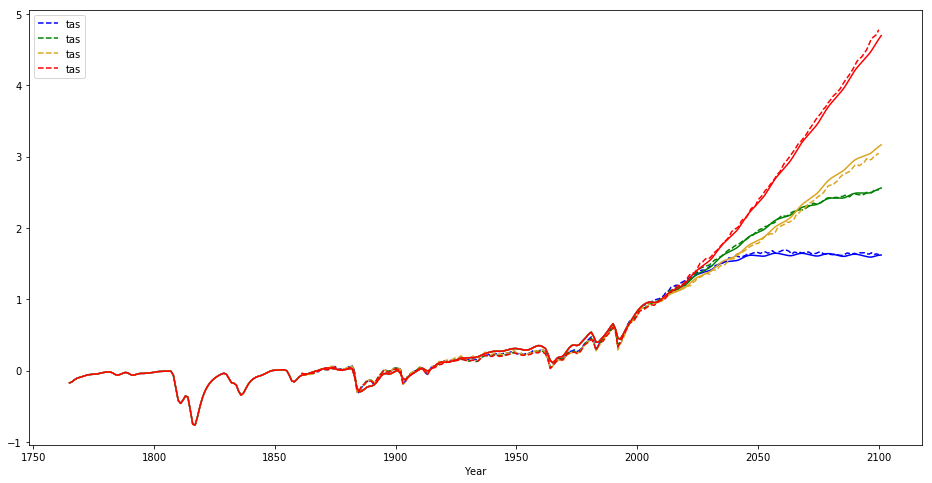

In [500]:
## Show the fit:

x = thermal_params_fit['x']
thermal_params.loc['d'] = [x[0],x[1]]
thermal_params.loc['q'] = np.array([x[2],x[3]])

print(thermal_params)

colors=['b','green','goldenrod','r']

fig,ax = plt.subplots(figsize=(16,8))

for i,s in enumerate(RCPs):
    model_run = UnFaIR(empty_emissions,total_forc[s],thermal_params=thermal_params)
    (model_run['T']['Total'] - model_run['T']['Total'].loc[1861:1880].mean()).plot(ax=ax,color=colors[i],label = s)
    (CMIP5_temps[s]-CMIP5_temps[s].loc[1861:1880].mean()).plot(ax=ax,linestyle='--',color=colors[i])
    

In [501]:
## Next we fit the forcing repsonse

RCP_forc_runs = {}

for s in RCPs:
    RCP_forc = pd.read_csv('./Conc_fit_data/RCP'+s+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)
    RCP_forc_runs[s] = pd.DataFrame(data=RCP_forc[['CO2_RF','CH4_RF','N2O_RF']].values,index = RCP_forc.index,columns = ['CO2','CH4','N2O'])
    
forcing_params = default_forcing_params()
    
def fit_rcp_forc(x,species):
    
    diff = 0
    
    for s in RCPs:
    
        model_run = step_forc(C = RCP_C[s][species].values,PI_conc = gas_params.loc['PI_conc',species], f = np.array([x[0],x[1],x[2]]))
    
        diff += np.sum((model_run.flatten() - RCP_forc_runs[s][species].values.flatten())**2)
        
    return diff
    
CO2_forc_param_fit = sp.optimize.minimize(fit_rcp_forc,default_forcing_params()['CO2'].values,args=('CO2'),method='Nelder-Mead')
CH4_forc_param_fit = sp.optimize.minimize(fit_rcp_forc,default_forcing_params()['CH4'].values,args=('CH4'),method='Nelder-Mead')
N2O_forc_param_fit = sp.optimize.minimize(fit_rcp_forc,default_forcing_params()['N2O'].values,args=('N2O'),method='Nelder-Mead')

         CO2       CH4       N2O
f1  5.398781  0.000583  0.000149
f2 -0.000046  0.000005 -0.000201
f3  0.000140  0.030661  0.121083


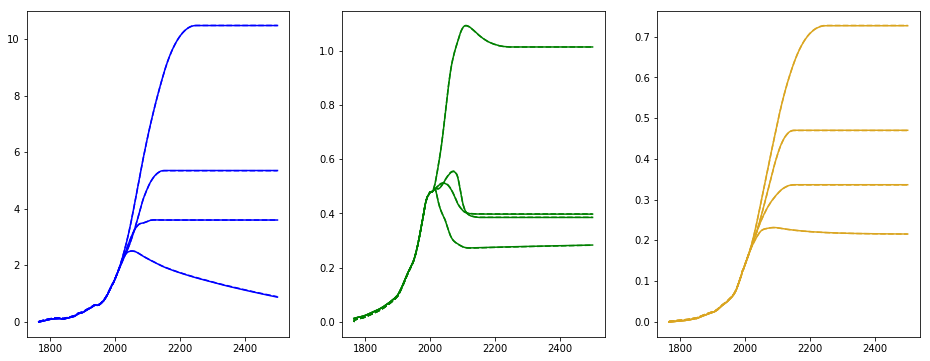

In [502]:
x = CO2_forc_param_fit['x']
forcing_params['CO2'] = np.array([x[0],x[1],x[2]])
x = CH4_forc_param_fit['x']
forcing_params['CH4'] = np.array([x[0],x[1],x[2]])
x = N2O_forc_param_fit['x']
forcing_params['N2O'] = np.array([x[0],x[1],x[2]])

print(forcing_params)

fig,ax=plt.subplots(1,3,figsize=(16,6))

for s in RCPs:
    for i,species in enumerate(['CO2','CH4','N2O']):
        model_run = step_forc(C = RCP_C[s][species].values,PI_conc = gas_params.loc['PI_conc',species], f = forcing_params[species].values)
        ax[i].plot(RCP_forc_runs[s].index,model_run,color=colors[i])
        ax[i].plot(RCP_forc_runs[s][species],color=colors[i],linestyle='--')

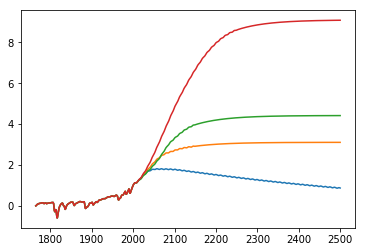

In [506]:
## Finally we fit the gas cycle with an input temp response (to prevent excessive endogenous variables)

RCP_T_response = {}

for s in RCPs:
    RCP_forc = pd.read_csv('./Conc_fit_data/RCP'+s+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)
    total_forc[s] = RCP_forc.TOTAL_INCLVOLCANIC_RF.values

for s in RCPs:
    
    RCP_T_response[s] = UnFaIR(empty_emissions(RCP_forc.index[0],RCP_forc.index[-1]),total_forc[s],forcing_params=forcing_params,thermal_params=thermal_params)['T']['Total']
    plt.plot(RCP_T_response[s])
    

In [508]:
gas_params = default_gas_params()

def fit_rcp_gas_cycles(x,species):
    
    fit_params = gas_params.copy()
    
    diff = 0
    
    if species == 'CO2':
        fit_params.loc[['r0','rC','rT'],species] = np.array([x[0],x[1],x[2]])
    if species == 'CH4':
        fit_params.loc[['r0','rT','rA','PI_conc'],species] = np.array([x[0],x[1],x[2],x[3]])
    if species == 'N2O':
        fit_params.loc[['r0','rA','PI_conc'],species] = np.array([x[0],x[1],x[2]])
        
    for s in RCPs:
        
        model_run = fit_gas_cycles(RCP_ems[s],RCP_T_response[s],fit_params)
        
        diff += np.sum((model_run[species].values.flatten() - RCP_C[s][species].values.flatten())**2)/np.sum((RCP_C[s][species].values.flatten())**2)
        
    return diff
    
CO2_rcp_params_fit = sp.optimize.minimize(fit_rcp_gas_cycles,[30,0.02,4],args=('CO2'),method='Nelder-Mead')
print('CO2 done',CO2_rcp_params_fit['message'])
CH4_rcp_params_fit = sp.optimize.minimize(fit_rcp_gas_cycles,[9,-0.3,0.0003,700.],args=('CH4'),method='Nelder-Mead')
print('CH4 done',CH4_rcp_params_fit['message'])
bnds=((50,100),(-1,0))
N2O_rcp_params_fit = sp.optimize.minimize(fit_rcp_gas_cycles,[70,-0.0009,273.],args=('N2O'),method='Powell')#,bounds=bnds)
print('N2O done',N2O_rcp_params_fit['message'])

CO2 done Optimization terminated successfully.
CH4 done Optimization terminated successfully.
N2O done Optimization terminated successfully.


                      CO2         CH4         N2O
a1               0.217300    1.000000    1.000000
a2               0.224000    0.000000    0.000000
a3               0.282400    0.000000    0.000000
a4               0.276300    0.000000    0.000000
tau1       1000000.000000    9.150000  116.000000
tau2           394.400000    1.000000    1.000000
tau3            36.540000    1.000000    1.000000
tau4             4.304000    1.000000    1.000000
r0              35.311728    9.776946   52.167921
rC               0.007143    0.000000    0.000000
rT               5.264299   -0.139233    0.000000
rA               0.000000    0.000048    0.008404
PI_conc        278.000000  668.325269  270.230342
emis2conc        0.468952    0.351714    0.200980 
 
          CO2       CH4       N2O
f1  5.398781  0.000583  0.000149
f2 -0.000046  0.000005 -0.000201
f3  0.000140  0.030661  0.121083 
 
            1         2
d  71.507508  3.284680
q   0.312707  0.425155


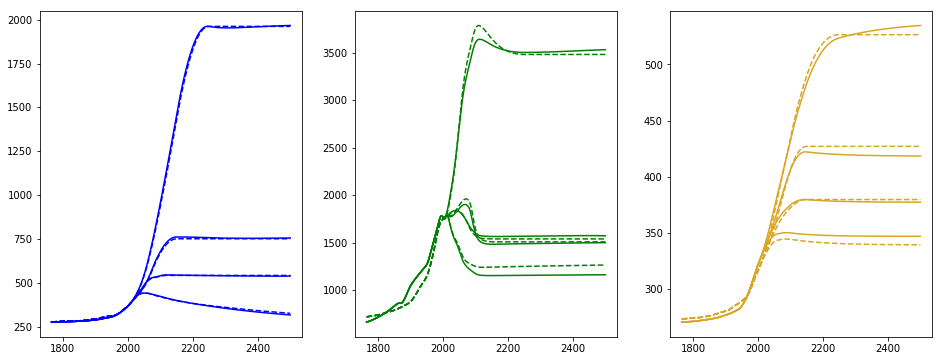

In [516]:
x = CO2_rcp_params_fit['x']
gas_params.loc['r0':'rT','CO2'] = np.array([x[0],x[1],x[2]])
x = CH4_rcp_params_fit['x']
gas_params.loc[['r0','rT','rA','PI_conc'],'CH4'] = np.array([x[0],x[1],x[2],x[3]])
x = N2O_rcp_params_fit['x']
gas_params.loc[['r0','rA','PI_conc'],'N2O'] = np.array([x[0],x[1],x[2]])

fig,ax=plt.subplots(1,3,figsize=(16,6))

model_run = {}

for s in RCPs:
    model_run[s] = UnFaIR(RCP_ems[s],otherforc[s],gas_params=gas_params,thermal_params=thermal_params,forcing_params=forcing_params)
    for i,species in enumerate(['CO2','CH4','N2O']):
        ax[i].plot(model_run[s]['C'][species],color=colors[i])
        ax[i].plot(RCP_C[s][species],color=colors[i],linestyle='--')
        
print(model_run[s]['gas_params'],'\n','\n',model_run[s]['forcing_params'],'\n','\n',model_run[s]['thermal_params'])

param_dict = {'gas_params':model_run[s]['gas_params'], 'thermal_params': model_run[s]['thermal_params'], 'forcing_params': model_run[s]['forcing_params']}

pickle.dump(param_dict,open('RCP_optimal_parameters.p', 'wb'))

(-0.4, 5.5)

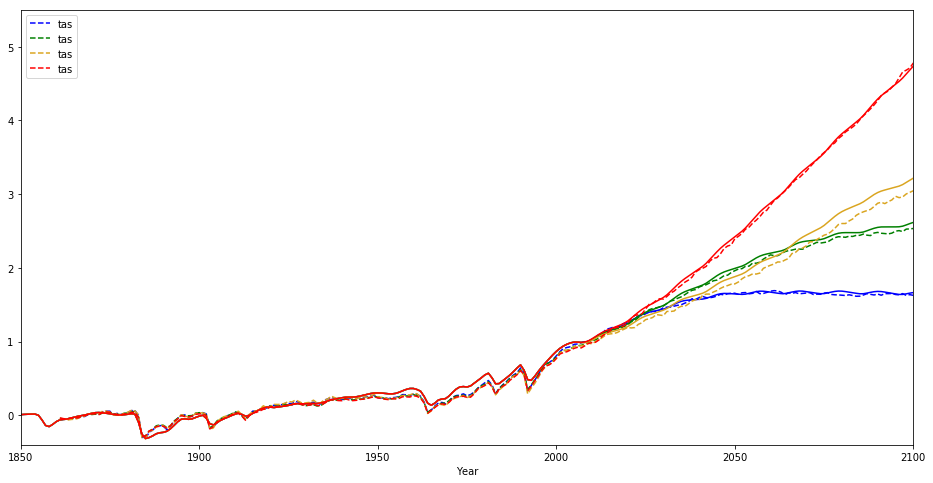

In [528]:
## How well does it match cmip5 temps?

fig,ax = plt.subplots(figsize=(16,8))

for i,s in enumerate(RCPs):
    (model_run[s]['T']['Total'] - model_run[s]['T']['Total'].loc[1861:1880].mean()).plot(ax=ax,color=colors[i],label = s)
    (CMIP5_temps[s]-CMIP5_temps[s].loc[1861:1880].mean()).plot(ax=ax,linestyle='--',color=colors[i])

ax.set_xlim(1850,2100)
ax.set_ylim(-0.4,5.5)